<a href="https://colab.research.google.com/github/ShreyPandit/Quantile-Regression_Lipschitz/blob/master/EnergyEfficiency_Quantile_Lipschitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

In [2]:
dataset = pd.read_csv("ENB2012_data.csv")

In [5]:
dataset

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
314,0.74,686.0,245.0,220.50,3.5,4,0.25,1,12.41,15.28
661,0.66,759.5,318.5,220.50,3.5,3,0.40,3,15.18,17.63
435,0.98,514.5,294.0,110.25,7.0,5,0.25,4,28.62,30.12
732,0.82,612.5,318.5,147.00,7.0,2,0.40,5,30.00,29.93
507,0.74,686.0,245.0,220.50,3.5,5,0.25,5,12.02,14.03
...,...,...,...,...,...,...,...,...,...,...
285,0.62,808.5,367.5,220.50,3.5,3,0.10,5,12.74,13.97
160,0.79,637.0,343.0,147.00,7.0,2,0.10,3,35.78,43.12
177,0.69,735.0,294.0,220.50,3.5,3,0.10,3,11.16,14.27
688,0.79,637.0,343.0,147.00,7.0,2,0.40,4,42.77,38.33


In [4]:
dataset = shuffle(dataset)

In [6]:
x_test = dataset.iloc[:50,:]

In [7]:
x_train = dataset.iloc[50:,:]

In [11]:
y_train = x_train.iloc[:,-2:]

In [12]:
y_test = x_test.iloc[:,-2:]

In [13]:
x_train = x_train.iloc[:,:-2]

In [15]:
x_test = x_test.iloc[:,:-2]

In [16]:
x_train_dummy = pd.get_dummies(x_train.iloc[:,-1])

In [18]:
x_test_dummy = pd.get_dummies(x_test.iloc[:,-1])

In [27]:
x_train['0'] = x_train_dummy.iloc[:,0]
x_train['1'] = x_train_dummy.iloc[:,1]
x_train['2'] = x_train_dummy.iloc[:,2]
x_train['3'] = x_train_dummy.iloc[:,3]
x_train['4'] = x_train_dummy.iloc[:,4]
x_train['5'] = x_train_dummy.iloc[:,5]

In [32]:
x_train.pop('X8')

305    1
578    2
116    2
524    5
569    1
      ..
285    5
160    3
177    3
688    4
397    3
Name: X8, Length: 718, dtype: int64

In [34]:
x_test['0'] = x_test_dummy.iloc[:,0]
x_test['1'] = x_test_dummy.iloc[:,1]
x_test['2'] = x_test_dummy.iloc[:,2]
x_test['3'] = x_test_dummy.iloc[:,3]
x_test['4'] = x_test_dummy.iloc[:,4]
x_test['5'] = x_test_dummy.iloc[:,5]

In [35]:
x_test.pop('X8')

314    1
661    3
435    4
732    5
507    5
17     0
763    5
21     0
750    5
274    5
417    3
230    4
193    4
622    2
742    5
272    5
373    2
649    3
481    5
700    4
354    2
356    2
335    1
631    3
498    5
233    4
426    3
717    4
257    5
186    3
353    2
715    4
97     2
234    4
676    4
282    5
696    4
540    1
444    4
686    4
174    3
681    4
381    2
729    5
491    5
653    3
646    3
212    4
146    3
508    5
Name: X8, dtype: int64

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [38]:
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [40]:
scaler.fit(y_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [44]:
y_train.shape

(718, 2)

In [122]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(50 ,activation='relu'))
model.add(layers.Dense(1,activation=keras.activations.softsign))

In [105]:
from tensorflow.keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [106]:
lrs = []
K1 = 0.
batch_size=32
num_classes = 2
from tqdm import tqdm

In [107]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    print("The value of K_z is ",Kz)
    K1 = (1/batch_size)*(Kz)*max(q,1-q)*(1/num_classes)
    lr = 1 / K1
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr


In [108]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [109]:
import tensorflow.keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [110]:
q = 0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [111]:
history=model.fit(x_train, y_train, epochs = 1000, batch_size = 32,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  13.039389
Epoch 0 LR = 5.166532176218914
Epoch 1/1000
23/23 [==============================] - 0s 6ms/step - loss: 0.0915 - val_loss: 0.0583
The value of K_z is  62.069946
Epoch 1 LR = 1.0853629667874023
Epoch 2/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0577
The value of K_z is  63.68884
Epoch 2 LR = 1.057774362887587
Epoch 3/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0571
The value of K_z is  65.153175
Epoch 3 LR = 1.0340005791980411
Epoch 4/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.0759 - val_loss: 0.0560
The value of K_z is  66.458725
Epoch 4 LR = 1.0136881361684238
Epoch 5/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0534
The value of K_z is  67.652664
Epoch 5 LR = 0.9957984931507906
Epoch 6/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0539
The value of K_z is  68.7

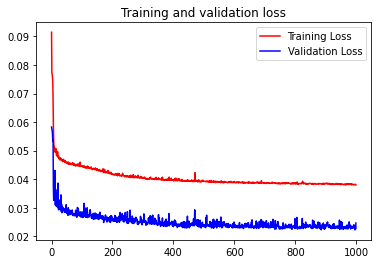

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [114]:
q = 0.05
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const=model.fit(x_train, y_train, epochs = 1000, batch_size = 32,validation_data=(x_test,y_test))

Epoch 1/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.2956 - val_loss: 0.2248
Epoch 2/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.2377 - val_loss: 0.1907
Epoch 3/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.2106 - val_loss: 0.1703
Epoch 4/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1934 - val_loss: 0.1575
Epoch 5/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1815 - val_loss: 0.1474
Epoch 6/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1719 - val_loss: 0.1392
Epoch 7/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1641 - val_loss: 0.1324
Epoch 8/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1265
Epoch 9/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1522 - val_loss: 0.1218
Epoch 10/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1476 - val_loss: 0.1177

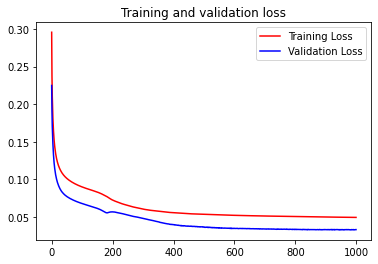

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history_const.history['loss']
val_loss = history_const.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


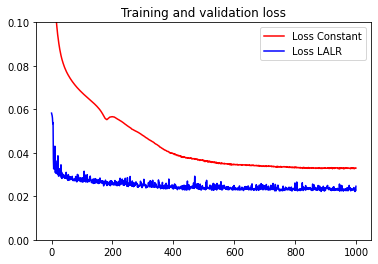

In [119]:
  %matplotlib inline
import matplotlib.pyplot as plt
loss_const = history_const.history['val_loss']
loss_lalr = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training and validation loss')
plt.ylim(0,0.1)
plt.legend()
plt.savefig('quantile_5.png')
plt.show()


In [120]:
q = 0.95
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history=model.fit(x_train, y_train, epochs = 1000, batch_size = 32,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

The value of K_z is  230.93536
Epoch 0 LR = 0.2917198126479402
Epoch 1/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.2168 - val_loss: 0.2080
The value of K_z is  230.93536
Epoch 1 LR = 0.2917198126479402
Epoch 2/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1915 - val_loss: 0.1993
The value of K_z is  230.93536
Epoch 2 LR = 0.2917198126479402
Epoch 3/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1847 - val_loss: 0.1943
The value of K_z is  230.93536
Epoch 3 LR = 0.2917198126479402
Epoch 4/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1805 - val_loss: 0.1908
The value of K_z is  230.93536
Epoch 4 LR = 0.2917198126479402
Epoch 5/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1774 - val_loss: 0.1880
The value of K_z is  230.93536
Epoch 5 LR = 0.2917198126479402
Epoch 6/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.1748 - val_loss: 0.1855
The value of K_z is  2

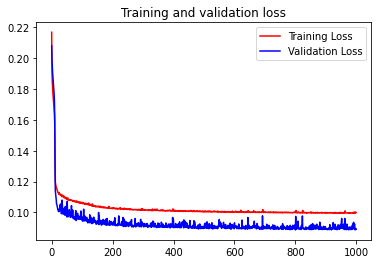

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [123]:
q = 0.95
model.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())
history_const=model.fit(x_train, y_train, epochs = 1000, batch_size = 32,validation_data=(x_test,y_test))

Epoch 1/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.3798 - val_loss: 0.3174
Epoch 2/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.3201 - val_loss: 0.2732
Epoch 3/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.2842 - val_loss: 0.2489
Epoch 4/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.2627 - val_loss: 0.2336
Epoch 5/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.2488 - val_loss: 0.2236
Epoch 6/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.2392 - val_loss: 0.2157
Epoch 7/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.2317 - val_loss: 0.2095
Epoch 8/1000
23/23 [==============================] - 0s 2ms/step - loss: 0.2257 - val_loss: 0.2043
Epoch 9/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.2208 - val_loss: 0.1997
Epoch 10/1000
23/23 [==============================] - 0s 1ms/step - loss: 0.2165 - val_loss: 0.1957

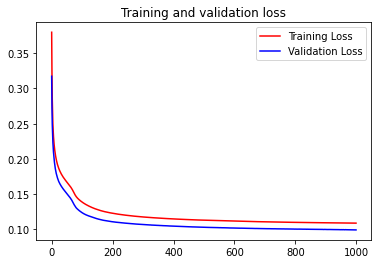

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history_const.history['loss']
val_loss = history_const.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


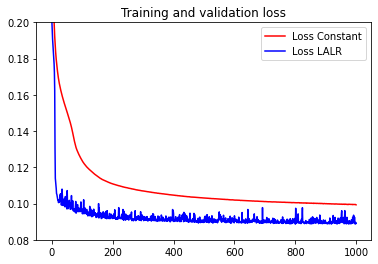

In [126]:
  %matplotlib inline
import matplotlib.pyplot as plt
loss_const = history_const.history['val_loss']
loss_lalr = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training and validation loss')
plt.ylim(0.08,0.2)
plt.legend()
plt.savefig('quantile_5.png')
plt.show()
